In [ ]:
!pip install pgmpy pandas
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from pgmpy.factors.discrete import TabularCPD
import pickle
from scipy import sparse
from sklearn.model_selection import train_test_split  # Import train_test_split

# Step 0: Mount Google Drive to save and load files
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/'  # Change this to your data folder in Google Drive

# Load data (assuming CSV files are stored in your Google Drive)
filtered_ratings = pd.read_csv(data_path + 'ratings_movies.csv')

print('RATINGS DATASET')
filtered_ratings


Mounted at /content/drive
RATINGS DATASET


,Unnamed: 0.1,Unnamed: 0,userId,movieId,rating,timestamp
0,0,159096,0,0,4.0,1619382182
1,1,159103,0,1,5.0,1619382182
2,2,159105,0,2,4.5,1619381466
3,3,159106,0,3,4.5,1619378551
4,4,159114,0,4,3.0,1619381471
...,...,...,...,...,...,...
9395,9395,31942801,199,45,4.5,1326447173
9396,9396,31942873,199,46,4.0,1544933125
9397,9397,31943023,199,47,4.0,1326447178
9398,9398,31943747,199,48,4.5,1326446513


In [ ]:
# Step 1: Preprocessing the dataset

# Drop unnecessary columns
filtered_ratings = filtered_ratings.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'timestamp'])

# Check for missing values
print(filtered_ratings.isnull().sum())

# Ensure userId and movieId are integers and rating is a float
filtered_ratings['userId'] = filtered_ratings['userId'].astype(int)
filtered_ratings['movieId'] = filtered_ratings['movieId'].astype(int)
filtered_ratings['rating'] = filtered_ratings['rating'].astype(float)

# Inspect the cleaned data
print(filtered_ratings.head())


userId     0
movieId    0
rating     0
dtype: int64
   userId  movieId  rating
0       0        0     4.0
1       0        1     5.0
2       0        2     4.5
3       0        3     4.5
4       0        4     3.0


In [ ]:
# Step 2: Split the data into training and testing sets

# Train-test split
train_ratings, test_ratings = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

# Extract user_ids and movie_ids from the train and test sets
user_ids_train = train_ratings['userId'].unique()
movie_ids_train = train_ratings['movieId'].unique()

print(f"Number of training samples: {len(train_ratings)}")
print(f"Number of test samples: {len(test_ratings)}")


Number of training samples: 7520
Number of test samples: 1880


Tính toán số lần xuất hiện và xác suất cho tập huấn luyện

In [ ]:
#tính toán số lần xuất hiện (count) và xác suất (probability) cho tập huấn luyện dựa trên các tương tác giữa người dùng và phim.
#Nhóm dữ liệu huấn luyện theo userId (ID người dùng) và movieId (ID phim), rồi đếm số lần mà mỗi người dùng đã đánh giá một bộ phim cụ thể.
user_movie_counts_train = train_ratings.groupby(['userId', 'movieId']).size().reset_index(name='count')
print("Filtered User-Movie Counts for Training Set (first 5 rows):")
print(user_movie_counts_train.head())

# Lấy tổng số lần đánh giá mỗi người dùng đã thực hiện trong tập huấn luyện
total_ratings_per_user_train = user_movie_counts_train.groupby('userId')['count'].sum().reset_index()
total_ratings_per_user_train.columns = ['userId', 'total_count']
print("Total Ratings Per User in Training Set:")
print(total_ratings_per_user_train.head())

# Hợp nhất để tính toán xác suất: P(movie | user) trong tập huấn luyện
#xác suất một người dùng đánh giá một bộ phim cụ thể
user_movie_counts_train = pd.merge(user_movie_counts_train, total_ratings_per_user_train, on='userId')
user_movie_counts_train['probability'] = user_movie_counts_train['count'] / user_movie_counts_train['total_count']
print("User-Movie Probability in Training Set (first 5 rows):")
print(user_movie_counts_train.head())


Filtered User-Movie Counts for Training Set (first 5 rows):
   userId  movieId  count
0       0        0      1
1       0        1      1
2       0        2      1
3       0        4      1
4       0        5      1
Total Ratings Per User in Training Set:
   userId  total_count
0       0           34
1       1           37
2       2           37
3       3           42
4       4           33
User-Movie Probability in Training Set (first 5 rows):
   userId  movieId  count  total_count  probability
0       0        0      1           34     0.029412
1       0        1      1           34     0.029412
2       0        2      1           34     0.029412
3       0        4      1           34     0.029412
4       0        5      1           34     0.029412



1.  User-Movie Counts for Training Set:grouping by userId and movieId to calculate the count of ratings. Each userId and movieId combination correctly shows the count of ratings.
2.  Total Ratings Per User in Training Set:calculates the total number of ratings each user has provided, which will be used to calculate the probability P(movie∣user).


1.   User-Movie Probability in Training Set:divides the individual count by the total count of ratings for each user, yielding the probability.





Tạo ma trận thưa cho P(movie | user)

In [ ]:
user_ids_train = user_movie_counts_train['userId'].unique()
movie_ids_train = user_movie_counts_train['movieId'].unique()
user_movie_counts_train['movieId_cat'] = pd.Categorical(user_movie_counts_train['movieId'], categories=movie_ids_train).codes
user_movie_counts_train['userId_cat'] = pd.Categorical(user_movie_counts_train['userId'], categories=user_ids_train).codes
row_indices_train = user_movie_counts_train['movieId_cat'].values
col_indices_train = user_movie_counts_train['userId_cat'].values
data_train = user_movie_counts_train['probability'].values
prob_movie_given_user_train_sparse = sparse.csr_matrix((data_train, (row_indices_train, col_indices_train)),
                                                       shape=(len(movie_ids_train), len(user_ids_train)))


Calculate movie-rating probabilities P(rating | user)

In [ ]:
# Step 1: Preprocess the dataset for ratings given users
# Group by userId and rating, and count the occurrences of each rating for each user
rating_given_user_counts = train_ratings.groupby(['userId', 'rating']).size().reset_index(name='count')

# Total ratings per user in the training set
total_ratings_per_user_train = rating_given_user_counts.groupby('userId')['count'].sum().reset_index()
total_ratings_per_user_train.columns = ['userId', 'total_count']

# Merge to calculate the probability P(rating | user)
rating_given_user_counts = pd.merge(rating_given_user_counts, total_ratings_per_user_train, on='userId')
rating_given_user_counts['probability'] = rating_given_user_counts['count'] / rating_given_user_counts['total_count']

# Check the first few rows of the resulting table
print("Rating Given User Counts in Training Set (first 5 rows):")
print(rating_given_user_counts.head())


Rating Given User Counts in Training Set (first 5 rows):
   userId  rating  count  total_count  probability
0       0     0.5      2           34     0.058824
1       0     2.0      1           34     0.029412
2       0     2.5      4           34     0.117647
3       0     3.0      9           34     0.264706
4       0     3.5      2           34     0.058824


In [ ]:
# Now create the rating CPD for 'rating' given 'user'
rating_values_train = rating_given_user_counts['rating'].unique()
user_ids_train = rating_given_user_counts['userId'].unique()

# Convert to categorical values (i.e., indices)
rating_given_user_counts['rating_cat'] = pd.Categorical(rating_given_user_counts['rating'], categories=rating_values_train).codes
rating_given_user_counts['userId_cat'] = pd.Categorical(rating_given_user_counts['userId'], categories=user_ids_train).codes

# Create the sparse matrix for rating given user
row_indices_rating_user = rating_given_user_counts['rating_cat'].values
col_indices_rating_user = rating_given_user_counts['userId_cat'].values
data_rating_user = rating_given_user_counts['probability'].values
prob_rating_given_user_train_sparse = sparse.csr_matrix((data_rating_user, (row_indices_rating_user, col_indices_rating_user)),
                                                         shape=(len(rating_values_train), len(user_ids_train)))

# Check the shape of the sparse matrix for 'rating' given 'user'
print(f"Rating Sparse Matrix Shape for prob_rating_given_user: {prob_rating_given_user_train_sparse.shape}")


Rating Sparse Matrix Shape for prob_rating_given_user: (10, 200)


In [ ]:
# Assuming the previous computations for the probabilities are correct
rating_values_train = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]  # Your actual rating values
user_ids_train = rating_given_user_counts['userId'].unique()

# Map rating values to indices
rating_value_to_index = {rating: idx for idx, rating in enumerate(rating_values_train)}

# Create the categorical variable for 'rating' (map actual values to indices)
rating_given_user_counts['rating_cat'] = rating_given_user_counts['rating'].map(rating_value_to_index)

# Create the sparse matrix for rating given user
row_indices_rating_user = rating_given_user_counts['rating_cat'].values
col_indices_rating_user = rating_given_user_counts['userId_cat'].values
data_rating_user = rating_given_user_counts['probability'].values
prob_rating_given_user_train_sparse = sparse.csr_matrix((data_rating_user, (row_indices_rating_user, col_indices_rating_user)),
                                                         shape=(len(rating_values_train), len(user_ids_train)))

# Check the shape of the sparse matrix for 'rating' given 'user'
print(f"Rating Sparse Matrix Shape for prob_rating_given_user: {prob_rating_given_user_train_sparse.shape}")


Rating Sparse Matrix Shape for prob_rating_given_user: (10, 200)


phân phối xác suất có điều kiện (CPD)

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import pickle

# Bayesian Network Model
model = BayesianNetwork([('user', 'movie'), ('user', 'rating')])

# Define the CPD for 'user'
cpd_user = TabularCPD(variable='user', variable_card=len(user_ids_train),
                      values=np.ones((len(user_ids_train), 1)) / len(user_ids_train),
                      state_names={'user': user_ids_train.tolist()})  # Set state names for 'user'

#  Định nghĩa CPD cho movie dựa trên user
#  sử dụng xác suất đã tính toán từ ma trận thưa trước đó.
cpd_movie = TabularCPD(variable='movie', variable_card=len(movie_ids_train),
                       values=prob_movie_given_user_train_sparse.toarray(),
                       evidence=['user'], evidence_card=[len(user_ids_train)])

# CPD cho rating dựa trên user
cpd_rating = TabularCPD(variable='rating', variable_card=len(rating_values_train),
                        values=prob_rating_given_user_train_sparse.toarray(),
                        evidence=['user'], evidence_card=[len(user_ids_train)],
                        state_names={'rating': rating_values_train, 'user': user_ids_train.tolist()})  # Set state names for both 'rating' and 'user'

# Add the CPDs to the model
model.add_cpds(cpd_user, cpd_movie, cpd_rating)

# Check if the model is valid
assert model.check_model(), "The model is not valid!"

# Save the model
with open('/content/drive/My Drive/Data/bayesian_network_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Inference
inference = VariableElimination(model)

In [ ]:
query_result =inference.query(variables=['rating'], evidence={'user': 1, 'movie': 10})
print(query_result)

+-------------+---------------+
| rating      |   phi(rating) |
+=============+===============+
| rating(0.5) |        0.0000 |
+-------------+---------------+
| rating(1)   |        0.0270 |
+-------------+---------------+
| rating(1.5) |        0.0000 |
+-------------+---------------+
| rating(2)   |        0.0000 |
+-------------+---------------+
| rating(2.5) |        0.0000 |
+-------------+---------------+
| rating(3)   |        0.1351 |
+-------------+---------------+
| rating(3.5) |        0.0000 |
+-------------+---------------+
| rating(4)   |        0.1892 |
+-------------+---------------+
| rating(4.5) |        0.0000 |
+-------------+---------------+
| rating(5)   |        0.6486 |
+-------------+---------------+


In [ ]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import mean_squared_error
import numpy as np

infer = VariableElimination(model)
# Store actual and predicted ratings for evaluation
predicted_ratings = []
actual_ratings = []

# Lặp qua bộ dữ liệu kiểm tra và thực hiện suy luận cho từng bộ phim và người dùng
for index, row in test_ratings.iterrows():
    user_id = int(row['userId'])  # Convert userId to integer
    movie_id = int(row['movieId'])  # Convert movieId to integer
    actual_rating = row['rating']  # Get actual rating from test data

    # Ensure the user_id and movie_id are in the training data
    if user_id in user_ids_train and movie_id in movie_ids_train:
        try:
            # thực hiện suy diễn để tính toán phân phối xác suất của rating khi biết chứng cứ về user và movie (ko có factor products)
            query_result = infer.query(variables=['rating'], evidence={'user': user_id, 'movie': movie_id})

            # Check if the distribution is valid
            if query_result.values.sum() > 0:
                # Extract the predicted rating (use argmax for highest probability)
                predicted_rating = np.argmax(query_result.values)  # Predicted rating index
                # Map the index back to the actual rating value (if necessary, based on your 'rating_values_train' list)
                predicted_ratings.append(predicted_rating)
                actual_ratings.append(actual_rating)
            else:
                print(f"Skipping user {user_id} and movie {movie_id} due to invalid probability distribution.")
        except Exception as e:
            # Print more details about the exception
            print(f"Inference failed for user {user_id} and movie {movie_id}: {e}")
    else:
        print(f"Skipping user {user_id} or movie {movie_id} because they are not in the training set.")

# Calculate performance (RMSE)
if predicted_ratings and actual_ratings:  # Ensure there's data to calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    print(f"Root Mean Square Error (RMSE) on test data: {rmse}")
else:
    print("No valid predictions made, unable to calculate RMSE.")


Root Mean Square Error (RMSE) on test data: 3.44076005952668


ƯU ĐIỂM:
- Mô hình có thể phân tích sự phụ thuộc giữa các yếu tố (user, movie, rating) và đưa ra các dự đoán xác suất.
- Mạng Bayes có khả năng xử lý dữ liệu thiếu, vì nó không yêu cầu mọi thông tin phải có mặt. Nếu không có thông tin về một số người dùng hoặc bộ phim trong quá trình kiểm tra, mô hình vẫn có thể đưa ra dự đoán dựa trên các quan hệ xác suất.
KHUYẾT ĐIỂM:
- Mức độ chính xác của mô hình, thể hiện qua RMSE = 3.44, có thể chưa đạt yêu cầu trong nhiều ứng dụng thực tế, đặc biệt trong các hệ thống gợi ý phức tạp.
- Nếu bộ dữ liệu rất lớn (ví dụ, có hàng triệu người dùng và bộ phim), Mạng Bayes có thể gặp khó khăn trong việc tính toán các xác suất có điều kiện cho tất cả các biến trong mạng. Việc tính toán xác suất và triển khai biến mất trong trường hợp dữ liệu lớn sẽ mất nhiều thời gian và tài nguyên.

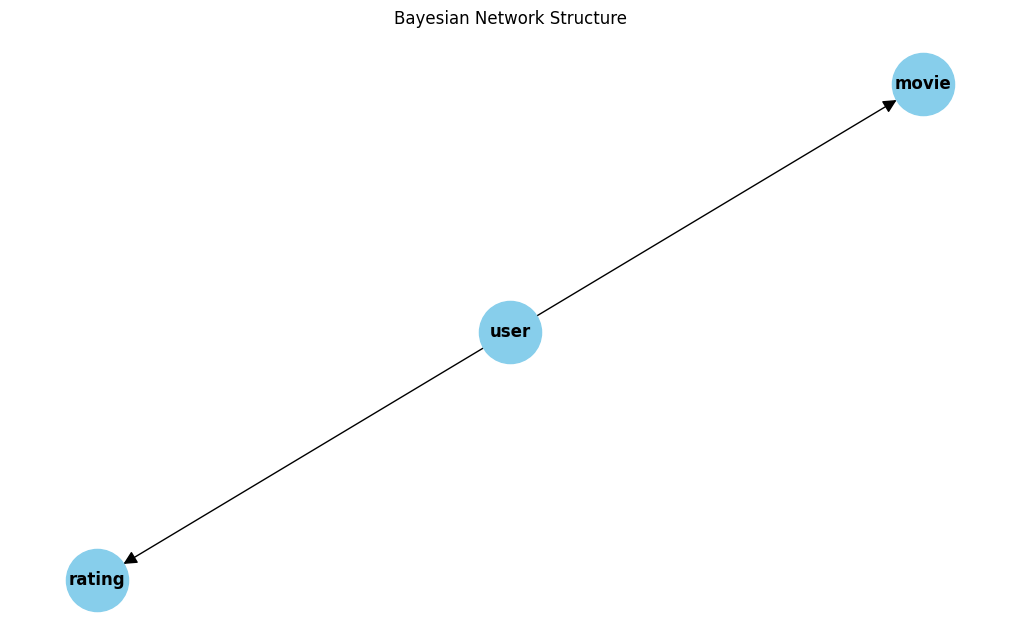

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph from the Bayesian Network
nx_graph = nx.DiGraph()  # Create a directed graph

# Add nodes and edges from the Bayesian Network model
nx_graph.add_nodes_from(model.nodes())
nx_graph.add_edges_from(model.edges())

# Draw the NetworkX graph with custom settings
plt.figure(figsize=(10, 6))
nx.draw(nx_graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title("Bayesian Network Structure")
plt.show()


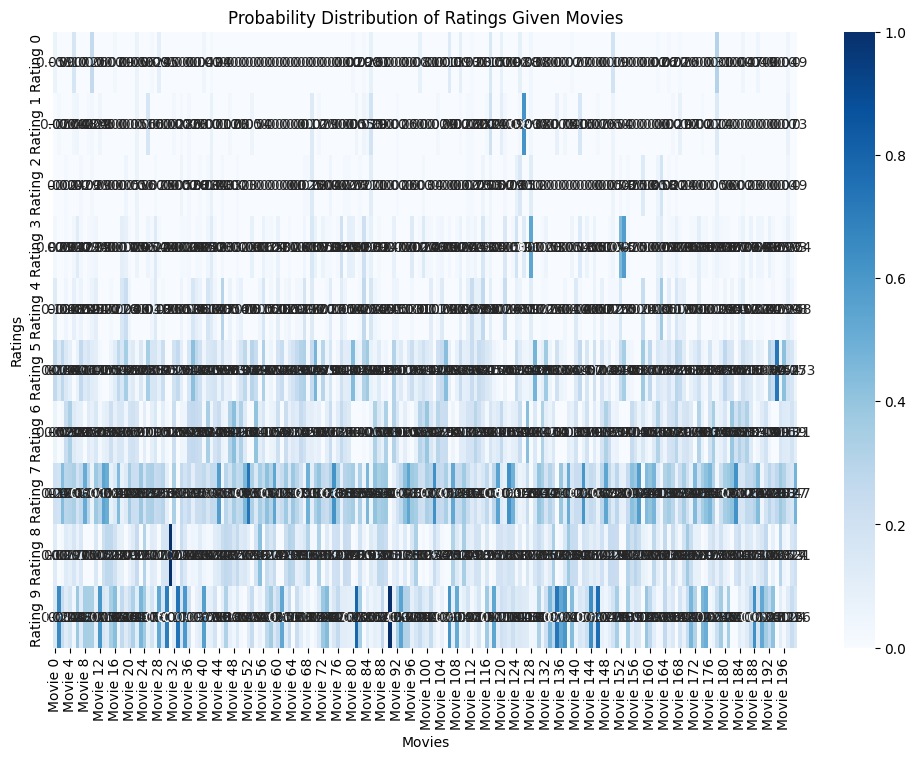

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the CPD for 'rating' to a DataFrame
rating_cpd = cpd_rating.get_values()
rating_df = pd.DataFrame(rating_cpd, columns=[f"Movie {i}" for i in range(rating_cpd.shape[1])], index=[f"Rating {i}" for i in range(rating_cpd.shape[0])])

# Create a heatmap to visualize the probability distribution of ratings given movies
plt.figure(figsize=(12, 8))
sns.heatmap(rating_df, annot=True, cmap="Blues")
plt.title("Probability Distribution of Ratings Given Movies")
plt.xlabel("Movies")
plt.ylabel("Ratings")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

movie_given_user_cpd = pd.DataFrame(
    prob_movie_given_user,
    columns=[f"User {i}" for i in range(prob_movie_given_user.shape[1])],
    index=[f"Movie {i}" for i in range(prob_movie_given_user.shape[0])]
)


limited_movie_given_user_cpd = movie_given_user_cpd.iloc[:10, :10]  # Top 10 movies and top 10 users

# Plot heatmap for the top 10 users and movies
plt.figure(figsize=(10, 8))
sns.heatmap(limited_movie_given_user_cpd, cmap='coolwarm', annot=True)
plt.title("Heatmap of Probability: Movies Given Users (Top 10)")
plt.show()


NameError: name 'prob_movie_given_user' is not defined

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2nsQS5eUSgfiEwNn8fuL9Djn6SU_2DK49nbMWAL4LR5T1w5FT



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!kill $(ps aux | grep ngrok | awk '{print $2}')

In [ ]:
streamlit_code = """
import streamlit as st
import pandas as pd
import pickle
from pgmpy.inference import VariableElimination
import os

# Define the path to your model file
model_path = '/content/drive/My Drive/Data/bayesian_network_model.pkl'

# Check if the model file exists
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # Initialize inference
    infer = VariableElimination(model)

    # Create sliders for user and movie selection
    user_id = st.slider('Select User ID', 0, 1000, 5)
    movie_id = st.slider('Select Movie ID', 0, 1000, 12)

    # Validate if the user_id and movie_id exist in the model's domain
    if 'user' in model.nodes() and 'movie' in model.nodes():
        # Get valid states from the model's CPDs
        valid_users = set()
        valid_movies = set()

        for cpd in model.get_cpds():
            if 'user' in cpd.variables:
                valid_users = set(cpd.state_names['user'])
            if 'movie' in cpd.variables:
                valid_movies = set(cpd.state_names['movie'])

        # Check if the selected IDs are valid
        if user_id not in valid_users or movie_id not in valid_movies:
            st.error(f"Invalid user or movie ID selected. Please select valid values.")
        else:
            try:
                # Query the Bayesian Network with the selected values
                query_result = infer.query(variables=['rating'], evidence={'user': user_id, 'movie': movie_id})

                # Define actual rating values (instead of 0-9 index)
                rating_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

                # Extract probabilities from query_result
                probabilities = query_result.values

                # Create a DataFrame with the correct rating values and their respective probabilities
                probabilities_df = pd.DataFrame({
                    'Rating': rating_values,
                    'Probability': probabilities
                })

                # Plot the bar chart
                st.bar_chart(probabilities_df.set_index('Rating')['Probability'])

            except Exception as e:
                st.error(f"Error during inference: {str(e)}")
    else:
        st.error("The model does not contain 'user' or 'movie' nodes. Please check the model structure.")

else:
    st.error(f"Model file '{model_path}' not found. Please check the file path.")

"""

# Open a file named 'varEliminate_MovieDataset.py' in write mode
with open('varEliminate_MovieDataset.py', 'w') as f:
    f.write(streamlit_code)

import os
import threading
from pyngrok import ngrok

# Function to run Streamlit in a separate thread
def run_streamlit():
    os.system('streamlit run varEliminate_MovieDataset.py')  # This runs the Streamlit app you saved earlier

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit)
thread.start()

# Expose the Streamlit app using ngrok
public_url = ngrok.connect(8501)  # Ensure the port is 8501
print(f"Streamlit app is running at: {public_url}")


Streamlit app is running at: NgrokTunnel: "https://da74-34-19-118-237.ngrok-free.app" -> "http://localhost:8501"
